In [16]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, TensorDataset, DataLoader
from torchvision import datasets, transforms
import pandas
import os
import seaborn as sns


In [13]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'split_dataset')

train_dir = os.path.join(data_dir, 'train')
test_studio_dir = os.path.join(data_dir, 'test_studio')
test_realworld_dir = os.path.join(data_dir, 'test_realworld')

# image preprocessing: resize and convert to tensor 
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_studio_dataset = datasets.ImageFolder(root=test_studio_dir, transform=transform)
test_realworld_dataset = datasets.ImageFolder(root=test_realworld_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_studio_loader = DataLoader(test_studio_dataset, batch_size=32, shuffle=False)
test_realworld_loader = DataLoader(test_realworld_dataset, batch_size=32, shuffle=False)

In [ ]:
# cnn_weight_model.pth; TRAIN_ACCURACY = 99 % , TEST_STUDI0_ACCURACY = 75%, TEST_REALWORLD_ACCURACY = 70%

class CNN(nn.Module):
    def __init__(self, in_channels=3, dropout_prob=0.5, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # new conv
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # adjust to output of last pool
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128→64
        x = self.pool(F.relu(self.conv2(x)))  # 64→32
        x = self.pool(F.relu(self.conv3(x)))  # 32→16
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
num_epochs=50
lr=0.001


In [7]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=lr)


In [8]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/50], Loss: 1.7110
Epoch [2/50], Loss: 1.4186
Epoch [3/50], Loss: 1.2813
Epoch [4/50], Loss: 1.1877
Epoch [5/50], Loss: 1.1266
Epoch [6/50], Loss: 1.0452
Epoch [7/50], Loss: 0.9780
Epoch [8/50], Loss: 0.9103
Epoch [9/50], Loss: 0.8569
Epoch [10/50], Loss: 0.7828
Epoch [11/50], Loss: 0.7315
Epoch [12/50], Loss: 0.6562
Epoch [13/50], Loss: 0.6096
Epoch [14/50], Loss: 0.5850
Epoch [15/50], Loss: 0.5437
Epoch [16/50], Loss: 0.5009
Epoch [17/50], Loss: 0.4684
Epoch [18/50], Loss: 0.4473
Epoch [19/50], Loss: 0.4150
Epoch [20/50], Loss: 0.3867
Epoch [21/50], Loss: 0.3699
Epoch [22/50], Loss: 0.3602
Epoch [23/50], Loss: 0.3436
Epoch [24/50], Loss: 0.3292
Epoch [25/50], Loss: 0.3107
Epoch [26/50], Loss: 0.3049
Epoch [27/50], Loss: 0.2915
Epoch [28/50], Loss: 0.2804
Epoch [29/50], Loss: 0.2785
Epoch [30/50], Loss: 0.2718
Epoch [31/50], Loss: 0.2593
Epoch [32/50], Loss: 0.2365
Epoch [33/50], Loss: 0.2562
Epoch [34/50], Loss: 0.2382
Epoch [35/50], Loss: 0.2411
Epoch [36/50], Loss: 0.2298
E

In [ ]:
#torch.save(model.state_dict(), "cnn_weights_model.pth")

In [ ]:
# Recreate the same model architecture

#model = CNN(in_channels=3, num_classes=len(train_dataset.classes))
#model.load_state_dict(torch.load("cnn_weights_model2.pth"))
#model.to(device)


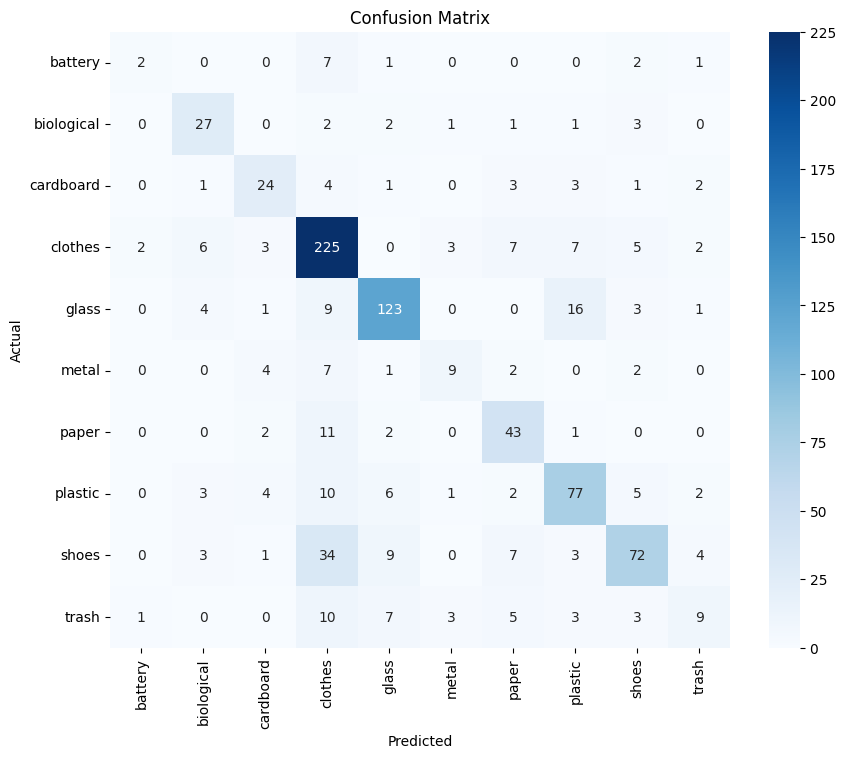

Test Accuracy: 0.6991
Precision: 0.6927
Recall:    0.6991
F1-score:  0.6875


In [ ]:
model.eval()
all_preds = []
all_labels = []
class_names=['battery','biological','cardboard','clothes','glass','metal','paper','plastic','shoes','trash']

with torch.no_grad():
    for batch_x, batch_y in test_realworld_loader: # change this to train_loader, test_studio_loader or test_realworld_loader
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        _, preds = torch.max(logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())



# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")